<a href="https://colab.research.google.com/github/dunliangyang2010/Deep-Learning-practice/blob/master/Kaggle_Diabetic_Retinopathy_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

In [3]:
# download from google drive or upload file by yourself
!gdown --id '1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4' --output retina-dataset.zip

# unzip dataset file
!unzip -q retina-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4
To: /content/retina-dataset.zip
100% 35.1M/35.1M [00:00<00:00, 112MB/s] 


#Data Visualization

In [4]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

retina-train/24163_right_1.jpeg


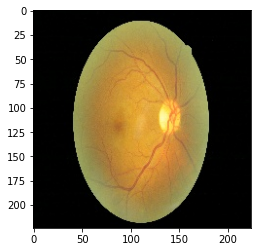

In [5]:
# np.random.randint(min, max, size)
idx = np.random.randint(0, len(paths), size=1)[0] #size=1代表產生元素只有1個的亂數list
path = paths[idx]
# path = 'retina-train/5258_right_2.jpeg'
# img.shape=(224,224,3)
img = cv2.imread(path)# [:,:,::-1] 
plt.imshow(img[:,:,::-1]) #BGR to RGB
print(path)

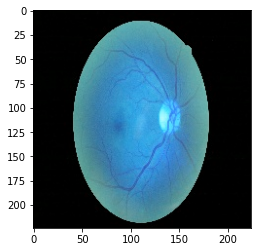

In [6]:
plt.imshow(img) # BGR

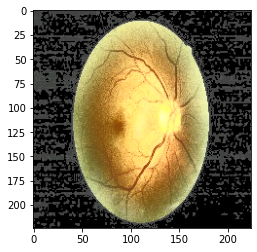

In [7]:
# Histogram Equalization 直方圖均化，增強明暗對比
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying equalize Hist operation on Y channel. #Y亮度
y_eq = cv2.equalizeHist(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)

In [8]:
# os.path.split(path): 'retina-train/4370_right_1.jpeg' -> ('retina-train', '4370_right_1.jpeg')
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])

all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~2
print(all_cls[:3])

['35142_right_0.jpeg', '7279_left_2.jpeg', '3420_right_1.jpeg']
[0, 2, 1]


<BarContainer object of 3 artists>

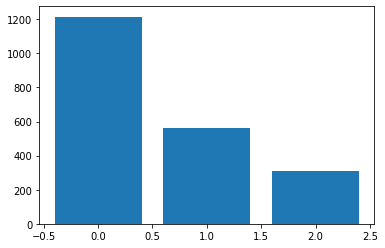

In [9]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

# Build Transfer Learning Model

In [10]:
# clear graph
tf.keras.backend.clear_session()

In [11]:
# Model1 Transfer Learning - Xception : 
base_model = tf.keras.applications.Xception(include_top=False, 
                      weights='imagenet',
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
# =============
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Freeeze layers
for l in base_model.layers[:]:
    l.trainable = False

model = models.Model(base_model.input, predictions)

83697664/83683744 [==============================] - 1s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
# Model2 Transfer Learning - EfficientNetB0 : 

base_model = tf.keras.applications.EfficientNetB0(include_top=False, 
                                                  weights='imagenet',
                                                #   weights=None, 
                                                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
# =============
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Freeeze layers
for l in base_model.layers[:]:
    l.trainable = False

model = models.Model(base_model.input, predictions)

In [ ]:
model.summary()

In [ ]:
# Model 3: Extract features from an arbitrary intermediate layer with EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False, 
                                                  weights='imagenet', 
                                                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

# get layer by name
features = base_model.get_layer('block2a_expand_conv').output
# get layer by layer index
# features = base_model.layers[17].output

x = layers.GlobalAveragePooling2D()(features)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = models.Model(base_model.input, predictions)

In [ ]:
model.summary()

# Prepare Data

In [13]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [14]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))
    
    #tqdm進度條, 可封裝任意的迭代器 tqdm(iterator)
    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        # # preprocess by histogram equlization
        # img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        # y, cr, cb = cv2.split(img_y_cr_cb)
        # # Applying equalize Hist operation on Y channel.
        # y_eq = cv2.equalizeHist(y)
        # img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
        # img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)

        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        # img = tf.keras.applications.efficientnet.preprocess_input(img)
        img = tf.keras.applications.xception.preprocess_input(img)
        # 
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes) # one-hot encoding
        return x_data, y_data
    else:
        return x_data

In [15]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:00<00:00, 527.08it/s]


In [16]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

# Training

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [24]:
model.compile(optimizer='adam', 
      loss=losses.categorical_crossentropy, 
      metrics=[metrics.categorical_accuracy])

In [25]:
logs = model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_val, y_val),
          callbacks=[callback])

Epoch 1/20
53/53 [==============================] - 25s 419ms/step - loss: 0.5481 - categorical_accuracy: 0.7572 - val_loss: 0.7683 - val_categorical_accuracy: 0.6435
Epoch 2/20
53/53 [==============================] - 21s 400ms/step - loss: 0.5220 - categorical_accuracy: 0.7638 - val_loss: 0.7923 - val_categorical_accuracy: 0.6722
Epoch 3/20
53/53 [==============================] - 22s 417ms/step - loss: 0.5418 - categorical_accuracy: 0.7614 - val_loss: 0.7666 - val_categorical_accuracy: 0.6699
Epoch 4/20
53/53 [==============================] - 21s 400ms/step - loss: 0.5287 - categorical_accuracy: 0.7590 - val_loss: 0.7708 - val_categorical_accuracy: 0.6411
Epoch 5/20
53/53 [==============================] - 21s 400ms/step - loss: 0.5173 - categorical_accuracy: 0.7584 - val_loss: 0.8665 - val_categorical_accuracy: 0.6435
Epoch 6/20
53/53 [==============================] - 21s 399ms/step - loss: 0.5071 - categorical_accuracy: 0.7782 - val_loss: 0.8460 - val_categorical_accuracy: 0.631

# Make Submission file
Kaggle: https://www.kaggle.com/c/retinopathy-classification-sai/data

In [26]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,2
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,2
518,9673_right.jpeg,0
519,9690_left.jpeg,0
520,9717_right.jpeg,0
